# My Capstone Project: Using Object Detection to Classify Amenities in Vacation Rental Listings

by Jordan Darbyshire

## **Project Overview**

### Motivation

The purpose of this project to identify objects from images of homes uploaded onto vacation rental sites. Potential customers browsing vacation rental sites are looking for specific amenities in their vacation rental. For example, they want an oven to cook in, a pool to swim in, a pool table for entertainment... the list goes on. When a property owner creates an ad on a vacation rental website, they would usually manually type in their amenities or select from a large list. Inaccurate amenities can result in lost revenue due to bad reviews or last-minute cancellations.

Users of the website will search for properties based on their desired amenities, and will be shown a list of properties based on their preferences. What if there was an easier way to add amenities to the listing, simply by uploading the property images without the manual labor? This is where Object Detection come in.

### Inspiration

The inspiration for this project comes from an [article](https://medium.com/airbnb-engineering/amenity-detection-and-beyond-new-frontiers-of-computer-vision-at-airbnb-144a4441b72e) I came across that highlighted an Airbnb computer vision project where they aim to detect room type by the types of objects identified in their listing photos.

I was interested in this project because of my interest in the Computer Vision field, which is still rapidly evolving. I also have a love for travelling, and can draw on my experience in using vacation rental sites for this project. 


### Potential Applications

Any hotel or vacation rental site such as Vrbo, Hotels.com, TripAdvisor, etc.

## **Exploratory Data Analysis**

### About the dataset

The dataset I used for this Capstone project is Open Images V4 (OIDv4), which contains 1.99 million images spanning 600 classes. The dataset was produced by Google. It is the largest existing dataset with object location annotations, which are bounding boxes drawn by humans to ensure accuracy and consistency [Source](https://storage.googleapis.com/openimages/web/factsfigures_v4.html). The images often show complex scenes with several objects (8 annotated objects per image on average) [Source](https://arxiv.org/abs/1811.00982). There are annual competitions hosted by Kaggle based on this dataset, for the purpose of advancing the Computer Vision field.

I chose this dataset due to the number of classes applicable to my business problem. The inclusion of the bounding box "labels" was also a bonus. Without these labels, I would have had to create these manually. To begin this project, I decided that I would choose the most relevant 20 classes, based on amenities that would be desirable to the consumer. The image classes I chose are indoor objects that belong to these room types: Bedroom, Bathroom, Living Room, Kitchen, and Outdoor (Swimming pool).

### Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import urllib
import os
import cv2

import warnings
warnings.filterwarnings("ignore")

### Download the images

I quickly realized that the biggest challenge with starting a project for Object Detection is putting together a custom dataset to run models. Since the Open Images dataset is so large, it would be a monumental task to download the full dataset (split into 513GB for training, 12GB for validation, and 36GB for testing) and sort through it to get what I need. The Open Images website does not provide an option to download select classes of images. Fortunately, I discovered that there are a few open source solutions to this problem. I attempted a few different "toolkits" that promised to solve this problem by downloading only the desired classes.

The [OIDv4 ToolKit](https://github.com/EscVM/OIDv4_ToolKit) finally allowed me to obtain only the classes I was interested in from the Open Images dataset. 

In [ ]:
# Download the Toolkit:
#!git clone https://github.com/EscVM/OIDv4_ToolKit.git

In [ ]:
# Download train set images for desired classes
# The script below allowed me to copy and paste the commands into Anaconda prompt without manually editing each line:
#for name in classes:   
    #print(f"python main.py downloader --classes {name} --type_csv train --limit 750")

I capped the number of images at 750 after observing some classes had tens of thousands of images, while half of my desired classes had less than 750 for each class.

In [ ]:
# Look at count of .jpg files in the dataset folder
import pathlib

data_dir = ("data/Dataset_20")
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count 

### Examine the dataset

After completion of the downloading process, I ended up with 11,907 images (3 GB in size).

Every downloaded image is accompanied by a text file that contains the class name and the bounding box coordinates in Pascal VOC format (more on this later, refer to data dictionary).

### Explore Image Dimensions

In [ ]:
# Use OpenCV to read in an image, open a window to view the image
# OpenCV converts the image to a numpy array
example_image = cv2.imread("data/Dataset_20/Bathtub/00a60d051d75144f.jpg", cv2.IMREAD_UNCHANGED)

# Opens a window to display the image
cv2.imshow("image",example_image)
# Wait until user presses a key
cv2.waitKey(0)
# Closes window based on waitforkey parameter
cv2.destroyAllWindows() 

In [ ]:
# Get dimensions of an image using OpenCV
# This code is from https://www.tutorialkart.com/opencv/python/opencv-python-get-image-size/

# Read an image
image = cv2.imread("data/Dataset_20/Bathtub/00a60d051d75144f.jpg", cv2.IMREAD_UNCHANGED)
 
# Get dimensions of image using shape
dimensions = image.shape
 
# height, width, number of channels in image
height = image.shape[0]
width = image.shape[1]
channels = image.shape[2]
pixel_num = image.size
 
print("Image Dimension    : ",dimensions)
print("Image Height       : ",height)
print("Image Width        : ",width)
print("Number of Channels : ",channels)
print("Number of pixels   : ",pixel_num)

In [ ]:
# Look at the image array
# print(image)

### Visualize the dataset

In [ ]:
# WRITE A DOCSTRING FOR THIS FUNCTION

# This function reads through Dataset folders, returns a DataFrame with number of images per class and a visualization
# It was created with help from https://stackoverflow.com/questions/62114998/python-make-dictionary-with-folder-names-as-key-and-file-names-as-values
# and https://thispointer.com/python-pandas-how-to-convert-lists-to-a-dataframe/
import fnmatch
from collections import defaultdict

def visualize_dataset(path):
    
    data_dict=defaultdict(set)
    global data_df
    
    # This code will read the images from the Dataset folder, put them into a dictionary
    for path,dirs,files in os.walk(path):
        for f in fnmatch.filter(files,'*.jpg'):
            data_dict[os.path.basename(path)].add(f)
        
    # Get number of pictures per class, append values to lists (intermediary step to a DataFrame)
    key_list = []
    count_list = []

    # Get number of photos per class(folder)
    for k,v in data_dict.items():
        value = len(list(filter(None, v)))
        key_list.append(k)
        count_list.append(value)

    # Create a zipped list of tuples from above lists
    zippedList =  list(zip(key_list, count_list))

    data_df = pd.DataFrame(zippedList, columns = ["Class" , "Image_Count"])

    data_df = data_df.sort_values(by="Image_Count", ascending=False).reset_index(drop=True)

    print(data_df)
        
    # Make a plot of number of images per class
    plt.figure(figsize=(20,10))
    plt.bar(data_df["Class"], data_df["Image_Count"])
    plt.title("Number of images per class", size=26)
    plt.ylabel("Image count", size=20)
    plt.xticks(rotation=90, size=16)
    plt.yticks(size=16)
    plt.show()

In [ ]:
visualize_dataset("data/Dataset_20/")

### Class imbalance problem

We can see from the above graph that there is a serious issue with class imbalance in this dataset. However due to time constrains, I am going to drop 5 classes that are not well represented in the data. This will also going to help reduce training time by reducing the size of the dataset. A solution to this first problem is to employ image augmentation, where copies of images in the unbalanced classes are made by flipping, scaling, or skewing.

### Drop from 20 to 15 classes

In [ ]:
%pwd

In [ ]:
# Remove classes from Dataset folder
# import shutil

# to_delete = ["Oven", "Coffeemaker", "Microwave oven", "Washing machine", "Ceiling fan"]

# for folder in to_delete:

    # Removes entire folder and contents
    # shutil.rmtree(f"Dataset_20/{folder}")
    # print(f"The {folder} folder has been removed")

In [ ]:
visualize_dataset("data/Dataset_15/")

In [ ]:
# Look at count of .jpg files in the dataset folder

data_dir = ("data/Dataset_15")
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count 

## **Data Pre-processing**

In [ ]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

## Train/set split

Due to the file structure of my images and annotations, I used a script called "partition_dataset.py" from GitHub to split my image and XML data into 80-20 Train-test sets.

In [33]:
%cd C:\Users\jorda\Documents\Capstone

C:\Users\jorda\Documents\Capstone


In [ ]:
#!git clone https://github.com/armaanpriyadarshan/Training-a-Custom-TensorFlow-2.X-Object-Detector.git

In [53]:
# Run this command to split the data

!python partition_dataset.py -i data/Dataset_15/Toilet -o data/Dataset_15_copy_after_split -r 0.2 -x
print(f"The partition was successful")

The partition was successful


## Convert annotations to XML, CSV

In [ ]:
# Download tool to convert txt annotations to PASCAL VOC
#!git clone https://github.com/thehetpandya/OIDv4_annotation_tool.git

In [ ]:
# Now that annotations are in XML (Pascal), need to get them into a single csv file for Keras

In [ ]:
# Run the Pascal to CSV program
# Source Code: https://gist.github.com/rotemtam/88d9a4efae243fc77ed4a0f9917c8f6c
import glob
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     #int(root.find('size')[0].text),
                     #int(root.find('size')[1].text),
                     xmin,
                     ymin,
                     xmax,
                     ymax,
                     label
                     )
            xml_list.append(value)
    column_name = ['image_name', #'width', 'height',
                   'x_min', 'y_min', 'x_max', 'y_max', 'class_name']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
# Look at the train dataset
train_df = xml_to_csv("data/Dataset_15_split/train")
train_df

The train data set has 8,127 images, with 12,989 annotations (bounding boxes).

In [ ]:
# Look at the test dataset
test_df = xml_to_csv("data/Dataset_15_split/test")
test_df

The test data set has 2,032 images with 3,291 annotations (bounding boxes).

### Data Dictionary

The annotations are now in a format required for TensorFlow modelling. Column descriptions:
- image_name = name of the image
- x_min, y_min = coordinates of the top-left corner of the bounding box
- x_max, y_max = coordinates of bottom-right corner of the bounding box
- class_name = class that the image and bounding box belong to \

**Important note:** The bounding box coordinates are in **Pascal VOC** format. The coordinates refer to the pixel values of the image (see image below for example). Other commmon annotation formats are COCO and YOLO [Bounding box guide](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/).

<img src=https://albumentations.ai/docs/images/getting_started/augmenting_bboxes/bbox_formats.jpg>

In [ ]:
# Convert DataFrames to a CSV
train_df.to_csv("data/labels_train.csv")
test_df.to_csv("data/labels_test.csv")

Let's visualize the bounding boxes on the images to complete the pre-processing step.

In [ ]:
# Source code: https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/
def show_image_objects(image_row):
    
    data_folder = Path("data/Dataset_15_split/train")
    
    img_path = data_folder / image_row.image_name 
    box = [
        image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]

    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_box(draw, box, color=(255, 255, 0))

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [ ]:
show_image_objects(train_df.iloc[19])

Now we can move ahead and do some modelling!

## Prepare inputs for TensorFlow

Instructions taken from the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md):
1. Create Label Maps
2. Convert dataset to TFRecord file format

For every example in dataset, we need:\
    - An RGB image for the dataset encoded as jpeg or png.\
    - A list of bounding boxes for the image. Each bounding box should contain:\
        i. A bounding box coordinates (with origin in top left corner) defined by 4 floating point numbers - ymin, xmin, ymax, xmax. Note that we need to store the normalized coordinates (x / width, y / height) in the TFRecord dataset.\
        ii. The class of the object in the bounding box.


In [ ]:
# Clone the TensorFlow models repository
# !git clone https://github.com/tensorflow/models.git

**1. Create Label Maps** Now that the annotations are in CSV format, we also need to create a label map which is required to make TFRecords out of dataset.

In [ ]:
# Assign the classes to class list in order to make the label map
s = pd.Series(data_df["Class"])
class_list = s.values.tolist()
print(class_list)

In [ ]:
# Converting the list of classes to label_map.pbtxt

from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format


def convert_classes(classes, start=1):
    msg = StringIntLabelMap()
    for id, name in enumerate(classes, start=start):
        msg.item.append(StringIntLabelMapItem(id=id, name=name))

    text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')
    return text


if __name__ == '__main__':
    txt = convert_classes(class_list)
    print(txt)
    with open('label_map.pbtxt', 'w') as f:
        f.write(txt)

**2. Convert dataset to TFRecord file format**

Using the Label Map, can generate a tf.Example proto for images using a script based on the TensorFlow Object Detector API. I cloned the following repository, and used the "generate_tfrecord.py" script. 

In [ ]:
#!git clone https://github.com/armaanpriyadarshan/Training-a-Custom-TensorFlow-2.X-Object-Detector.git

In [ ]:
# Navigate to preprocessing folder in Tensorflow
%cd Tensorflow/scripts/preprocessing/

In [ ]:
# !python generate_tfrecord.py -x C:\Users\jorda\Documents\Capstone\Tensorflow\workspace\capstone\images\train -l C:\Users\jorda\Documents\Capstone\Tensorflow\workspace\capstone\annotations\label_map.pbtxt -o C:\Users\jorda\Documents\Capstone\Tensorflow\workspace\capstone\annotations\train.record

In [ ]:
!python generate_tfrecord.py -x C:\Users\jorda\Documents\Capstone\Tensorflow\workspace\capstone\images\test -l C:\Users\jorda\Documents\Capstone\Tensorflow\workspace\capstone\annotations\label_map.pbtxt -o C:\Users\jorda\Documents\Capstone\Tensorflow\workspace\capstone\annotations\test.record

Generation of the train and test TFRecords were successful.

## **Model Training - TensorFlow**

For this project I decided to make use of pre-trained models for object detection, rather than building a model from scratch. The benefit to this is that we are leveraging knowledge (features, weights) from previously trained models to apply to related datasets. In the case of computer vision, low-level features such as edges, shapes, corners and intensity can be shared among tasks (transfer learning). By usng pre-trained models we are saving time and computer resources which is what is needed for this large dataset and the task at hand (object detection).

## Train dataset with pre-trained models

System Setup:
- Windows 10
- Ryzen 7 AMD CPU
- NVIDIA GeForce GTX 1660-Ti / 6GB memory
- 16 GB RAM
- Tensorflow-GPU Version 2.3.0
- CUDA Toolkit 10.1
- cuDNN 7.6.5

I decided to make use of the GPU on my laptop to run the pre-trained models. I selected the following pre-trained models to train my amenity dataset:

| Pre-trained model |   Feature extractor  |                        Pros                        |                      Cons                     |
|:-----------------:|:--------------------:|:--------------------------------------------------:|:---------------------------------------------:|
|  SSD MobileNet V2 |      VGG16 (FPN)     | Works well on large objects                        | Doesn't fare well on small objects            |
|     RetinaNet     |    ResNet50 (FPN)    | Works well on multiple scales | None                                          |
|       YOLOv3      | Darknet53 (FPN-like) | Very fast, works well on small objects             | Doesn't fare well on medium and large objects |

I selected these models based on training speeds. YOLOv3 is the fastest, while RetinaNet is fast while being highly accurate. SSD MobileNet is inbetween in terms of speed and accuracy.

In [ ]:
# Import TensorFlow
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Show the TensorFlow version
print(tf.__version__)

Turn on memory growth for GPU by running the following code prior to allocating any tensors or executing any ops [Source: TensorFlow - Using a GPU](https://www.tensorflow.org/guide/gpu). Attempts to allocate only as much GPU memory as needed for the runtime allocations (Experienced errors previously).

In [ ]:
# Run the following code before training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


## Pre-trained model no. 1: SSD MobileNet V2

### Background:

MobileNet V2 is a Single Shot Detector (SSD) model that goes straight from image pixels to bounding box coordinates and class probabilities in a single forward pass. The model is able to detect multiple objects within the image. SSD is much faster compared with two-shot RPN based approaches. [Source](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11). SSD uses the VGG-16 model pre-trained on ImageNet as its base model for extracting useful image features. On top of VGG16, SSD adds several conv feature layers of decreasing sizes. They can be seen as a pyramid representation of images at different scales. The detection happens in every pyramidal layer, targeting at objects of various sizes [Source](https://lilianweng.github.io/lil-log/2018/12/27/object-detection-part-4.html#yolov2--yolo9000)

The loss function is a dynamically scaled cross-entropy loss, where the scaling factor decays to zero as confidence in the correct class increases. [Source](https://medium.com/analytics-vidhya/how-focal-loss-fixes-the-class-imbalance-problem-in-object-detection-3d2e1c4da8d7)

<img src=https://lilianweng.github.io/lil-log/assets/images/SSD-architecture.png>

### Training

In [ ]:
%cd C:\Users\jorda\Documents\Capstone\Tensorflow\workspace\capstone

In [ ]:
!python model_main_tf2.py \
    --model_dir=models/my_ssd_mobilenet_v2_fpnlite \
    --pipeline_config_path=models/my_ssd_mobilenet_v2_fpnlite/pipeline.config
    --alsologtostderr

In [ ]:
# Ensure GPU is being used
#!nvidia-smi

In [ ]:
# Start Tensorboard for monitoring training, navigate to TensorFlow/workspace/capstone
# !tensorboard --logdir=models\my_ssd_mobilenet_v2_fpnlite

Training started Sep 9 @ 1:55AM. Training ended 11:04AM. Training ran for 50,000 steps (50 epochs).

### Export Inference Graph from finished model

In [ ]:
# Navigate to TensorFlow/workspace/capstone
!python exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path models\my_ssd_mobilenet_v2_fpnlite\pipeline.config \
    --trained_checkpoint_dir models\my_ssd_mobilenet_v2_fpnlite \
    --output_directory exported-models\my_mobilenet_model

The above script creates a file called saved_'model.pb' which is the inference graph. Copy the 'label_map.pbtxt' file into this directory to make things a bit easier for testing.

### Test out finished model

In [ ]:
# Visualize test image with OpenCV
!python TF-image-od.py \
    --image images/test/4ad2b99ef5fb838c.jpg

### Evaluate model

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
tf.executing_eagerly()

In [ ]:
tf.compat.v1.enable_eager_execution()

In [ ]:
tf.executing_eagerly()

In [ ]:
!python model_main_tf2.py \
    --pipeline_config_path=exported-models\my_mobilenet_model\pipeline.config \
    --model_dir=exported-models\my_mobilenet_model\saved_model \
    --checkpoint_dir=exported-models\my_mobilenet_model\checkpoint \
    --alsologtostderr

In [ ]:
# Does not work due to eager execution (old script that does not work with newer version of Tensorflow)
# Tried to use older version of Tensorflow, did not work because my system is not compatible
!python eval.py \
    --logtostderr \
    --checkpoint_dir=exported-models/my_mobilenet_model/checkpoint/model.ckpt \
    --eval_dir=exported-models/my_mobilenet_model/saved_model/eval \
    --pipeline_config_path=exported-models/my_mobilenet_model/pipeline.config

### View evaluation results in Tensorboard

In [ ]:
# Start TensorBoard to monitor training
!tensorboard --logdir=exported-models\my_mobilenet_model\saved_model\eval

## Pre-trained model no. 2: RetinaNet + Keras

### Background

RetinaNet solved the problem of the extreme foreground-background class imbalance problem in one-stage detectors by introducing Focal Loss. 

In RetinaNet, a one-stage detector, by using focal loss, lower loss is contributed by “easy” negative samples so that the loss is focusing on “hard” samples, which improves the prediction accuracy. With ResNet+FPN as backbone for feature extraction, plus two task-specific subnetworks for classification and bounding box regression, forming the RetinaNet, which achieves state-of-the-art performance, outperforms Faster R-CNN, the well-known two-stage detectors.

RetinaNet is built on top of two crucial concepts - Focal Loss and Featurized Image Pyramid:

1. **Focal Loss** is designed to mitigate the issue of extreme imbalance between background and foreground with objects of interest. It assigns more weight on hard, easily misclassified examples and small weight to easier ones.

2. **The Featurized Image Pyramid** is the vision component of RetinaNet. It allows for object detection at different scales by stacking multiple convolutional layers [Source](https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/).

<img src=https://developers.arcgis.com/assets/img/python-graphics/retinanet.png>

Used this [guide](https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/) to train a RetinaNet object detection model.

In [ ]:
#!git clone https://github.com/fizyr/keras-retinanet.git

In [ ]:
# Install keras-retinanet
# %cd keras-retinanet/
#! pip install .

### Get data in format required for Keras

In [ ]:
# Keras requires two input files

ANNOTATIONS_FILE = "annotations.csv"
CLASSES_FILE = "classes.csv"

In [ ]:
# Look at class list created previously
class_list

In [ ]:
# Create numbers for the classes (indexing starts at 0)
class_number = list(np.arange(0, 20))
class_number

In [ ]:
# Put the two lists together into a DataFrame
class_tuples = list(zip(class_list,class_number))
classes_df = pd.DataFrame(class_tuples)

In [ ]:
# Headers need to be removed
classes_df.to_csv(CLASSES_FILE, index=False, header=None)

In [ ]:
# Headers need to be removed
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

### Training

Download pre-trained model from RetinaNet

In [ ]:
 cd C:\Users\jorda\Documents\Capstone\keras-retinanet\keras_retinanet\bin

In [ ]:
# Download pre-trained model
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

In [ ]:
# Start TensorBoard to monitor training
#!tensorboard --logdir=keras_retinanet\bin\logs\train

In [ ]:
# Ensure GPU is being used
# !nvidia-smi

In [ ]:
# Initiate training for 50 epochs
!python train.py \
    --tensorboard-dir logs \
    --freeze-backbone \
    --random-transform \
    --weights {PRETRAINED_MODEL} \
    --batch-size 5 \
    --steps 500 \
    --epochs 50 \
    --gpu 0\
    --multi-gpu 1 \
    csv annotations.csv classes.csv

Training started Sep 8 @ 2:15AM. Training ended 9:36AM. Training ran for 50 epochs.

### Evaluate model

In [ ]:
# Load in last checkpoint
model_path = os.path.join("snapshots", sorted(os.listdir("snapshots"), reverse=True)[0])
model_path

In [ ]:
# Specify the type of feature extraction (backbone) used for the object detection
model = models.load_model(model_path, backbone_name="resnet50")
# Convert model for Keras
model = models.convert_model(model)

In [ ]:
# Read in the label classes
labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()
labels_to_names

In [ ]:
# Function #1: Get predictions from model
def predict(image):

    image = preprocess_image(image.copy())
    # Re-size and preprocess the image
    image, scale = resize_image(image)
    # Add additional dimension to image tensor
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    # Rescale detected boxes based on the resized iamge scale
    boxes /= scale
    # Return all predictions
    return boxes, scores, labels

In [ ]:
# Function #2: Draw detected boxes on the image
# Set minimum threshold score
THRES_SCORE = 0.3

def draw_detections(image, boxes, scores, labels):

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [ ]:
# Function #3: Show detected objects along with predictions
def show_detected_objects(image_row):

    img_path = image_row.image_name
    image = read_image_bgr(img_path)
    boxes, scores, labels = predict(image)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    true_box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]

    draw_box(draw, true_box, color=(255, 255, 0))
    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.imsave('predicted_image.jpg', draw)
    
    plt.show()

In [ ]:
# Will be running detections on the test images
test_df.head()

In [ ]:
cd test

In [ ]:
%cd keras-retinanet\keras_retinanet\bin\test

In [ ]:
# Yellow boxes are the ground-truth boxes (the true hand labeled bounding box)
# Other colors are the predicted boxes with confidence score above 0.3
show_detected_objects(test_df.iloc[100])

By browsing through a few of the test images, a little less than 50% are classified correctly.

## Pre-trained model no. 3: YOLOv3

### Background:

I decided to try YOLOv3 due to speed (100x faster than Fast R-CNN). YOLO (You Only Look Once) looks at the whole image at test time so it's predictions are informed by global context in the image. It makes predictions with a single network evaluation unlike systems like R-CNN which require thousands for a single image [Source](https://pjreddie.com/darknet/yolo/). YOLO3 uses Darknet-53 as its backbone feature extractor, which has 53 convolutional layers trained on ImageNet. For the task of detection, 53 more layers are stacked onto it, giving a 106 layer fully convolutional underlying architecture for YOLOv3 [Source](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b). YOLO3 is better (in terms of Average Precision) than Faster R-CNN for small objects, but behind RetinaNet. It is not as accurate as other models for medium and large objects.

YOLOv3 makes detections on 3 different scales.  YOLO is a fully convolutional network and its eventual output is generated by applying a 1 x 1 kernel on a feature map. In YOLO v3, the detection is done by applying 1 x 1 detection kernels on feature maps of three different sizes at three different places in the network [Source](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b).

<img src=https://miro.medium.com/max/1000/1*d4Eg17IVJ0L41e7CTWLLSg.png>

### Get data in format required for YOLO

For the annotations, YOLO required that they bounding boxes are in normalized coordinates (numbers between 0 and 1)

In [ ]:
# Clone the windows version of Darknet:
# !git clone https://github.com/AlexeyAB/darknet.git

### Get Images into Numpy Arrays

In order for Images to go into a TensorFlow model, they to be read and decoded into integer tensors, then converted to floating point and normalized to small values (between 0 and 1).

In [ ]:
# The below function converts all of the images into numpy arrays
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
from PIL import Image
# We need to get all of the images into arrays, which will be used to combine with the bounding boxes & labels
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

## Image Classification

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Pre-trained model no. 1: SSD MobileNet V2

In [54]:
# Import the pretrained MobileNet V2 model and do not include the final layer:
print('loading model...')
base_model = MobileNetV2(weights='imagenet', include_top=False)
print('model loaded!')

In [55]:
# Final layers:
# Assign the output of this base_model to a variable:
base_model_out = base_model.output

# Add a pooling layer:
base_model_out = GlobalAveragePooling2D()(base_model_out)

# Add 3 dense layers so that the model can learn aspects of our new dataset 
# and classify for better results.
base_model_out = Dense(243, activation='relu')(base_model_out) 
base_model_out = Dense(243, activation='relu')(base_model_out)
base_model_out = Dense(81, activation='relu')(base_model_out)

# Add a final layer with 3 neurons, one for each class in our dataset 
# using a softmabase_model_out activation function:
preds = Dense(15, activation='softmax')(base_model_out)

# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = base_model.input, 
              outputs = preds)

In [56]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [57]:
# Lock weights in pre-trained model
for layer in model.layers[:87]:
    layer.trainable=False
    
for layer in model.layers[87:]:
    print(layer.name)
    layer.trainable=True

block_9_depthwise_relu
block_9_project
block_9_project_BN
block_9_add
block_10_expand
block_10_expand_BN
block_10_expand_relu
block_10_depthwise
block_10_depthwise_BN
block_10_depthwise_relu
block_10_project
block_10_project_BN
block_11_expand
block_11_expand_BN
block_11_expand_relu
block_11_depthwise
block_11_depthwise_BN
block_11_depthwise_relu
block_11_project
block_11_project_BN
block_11_add
block_12_expand
block_12_expand_BN
block_12_expand_relu
block_12_depthwise
block_12_depthwise_BN
block_12_depthwise_relu
block_12_project
block_12_project_BN
block_12_add
block_13_expand
block_13_expand_BN
block_13_expand_relu
block_13_pad
block_13_depthwise
block_13_depthwise_BN
block_13_depthwise_relu
block_13_project
block_13_project_BN
block_14_expand
block_14_expand_BN
block_14_expand_relu
block_14_depthwise
block_14_depthwise_BN
block_14_depthwise_relu
block_14_project
block_14_project_BN
block_14_add
block_15_expand
block_15_expand_BN
block_15_expand_relu
block_15_depthwise
block_15_dept

### Load data

In [58]:
%cd C:\Users\jorda\Documents\Capstone\

C:\Users\jorda\Documents\Capstone


In [59]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

In [60]:
train_generator = train_datagen.flow_from_directory('data/Dataset_15_after_split/train', # path to the training data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 8119 images belonging to 15 classes.


In [61]:
label_map = train_generator.class_indices
label_map

{'Bathtub': 0,
 'Bed': 1,
 'Billiard table': 2,
 'Chair': 3,
 'Couch': 4,
 'Fireplace': 5,
 'Gas stove': 6,
 'Kitchen & dining room table': 7,
 'Lamp': 8,
 'Refrigerator': 9,
 'Sink': 10,
 'Stairs': 11,
 'Swimming pool': 12,
 'Television': 13,
 'Toilet': 14}

In [62]:
from sklearn.preprocessing import LabelEncoder

# Instantiating the encoder:
my_encoder = LabelEncoder()

In [63]:
# Fitting the encoder with the labels from 'label_map':
my_encoder.fit(list(label_map.keys()))

LabelEncoder()

In [64]:
# Verifying the encoding:
for i, j in enumerate(my_encoder.classes_):
    print(f'{i}: {j}')

0: Bathtub
1: Bed
2: Billiard table
3: Chair
4: Couch
5: Fireplace
6: Gas stove
7: Kitchen & dining room table
8: Lamp
9: Refrigerator
10: Sink
11: Stairs
12: Swimming pool
13: Television
14: Toilet


## Train the model

In [65]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
step_size_train = train_generator.n//train_generator.batch_size + 1

# 'train_generator.n' = 182 (number of datapoints; i.e. images)
# 'train_generator.batch_size' = 32 (size of batches previously passed in)
# 'step_size_train' = 254 (step size; needs to be int)

In [89]:
step_size_train

254

In [67]:
history = model.fit_generator(generator = train_generator, 
                    steps_per_epoch = step_size_train, 
                    epochs = 20)

Epoch 1/20
254/254 [==============================] - 135s 533ms/step - loss: 1.3262 - accuracy: 0.5942
Epoch 2/20
254/254 [==============================] - 96s 378ms/step - loss: 0.9036 - accuracy: 0.7226
Epoch 3/20
254/254 [==============================] - 95s 373ms/step - loss: 0.7452 - accuracy: 0.7651
Epoch 4/20
254/254 [==============================] - 96s 378ms/step - loss: 0.6270 - accuracy: 0.8022
Epoch 5/20
254/254 [==============================] - 95s 374ms/step - loss: 0.5326 - accuracy: 0.8315
Epoch 6/20
254/254 [==============================] - 95s 373ms/step - loss: 0.4691 - accuracy: 0.8508
Epoch 7/20
254/254 [==============================] - 95s 376ms/step - loss: 0.4090 - accuracy: 0.8650
Epoch 8/20
254/254 [==============================] - 96s 377ms/step - loss: 0.3447 - accuracy: 0.8893
Epoch 9/20
254/254 [==============================] - 96s 378ms/step - loss: 0.3039 - accuracy: 0.9044
Epoch 10/20
254/254 [==============================] - 96s 377ms/step - 

### Plot Accuracy Vs Loss

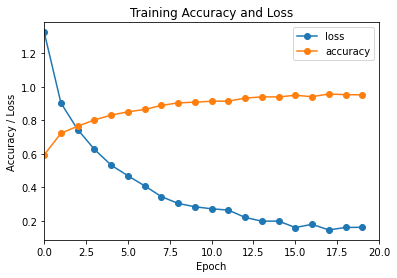

In [74]:
plt.figure()
plt.plot(history.history['loss'], marker='o', label='loss')
plt.plot(history.history['accuracy'], marker='o', label='accuracy')
plt.title('Training Accuracy and Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.xlim(0, 20)
plt.show()

### Evaluate model

In [94]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [96]:
desired_batch_size=15

test_generator = test_datagen.flow_from_directory('data/Dataset_15_after_split/test', # path to the training data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=desired_batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/desired_batch_size))

Found 2040 images belonging to 15 classes.


In [97]:
np.array(list(label_map.keys()))

array(['Bathtub', 'Bed', 'Billiard table', 'Chair', 'Couch', 'Fireplace',
       'Gas stove', 'Kitchen & dining room table', 'Lamp', 'Refrigerator',
       'Sink', 'Stairs', 'Swimming pool', 'Television', 'Toilet'],
      dtype='<U27')

In [98]:
# Return an array of probabilities
prediction = model.predict_generator(test_generator, steps = np.ceil(nb_samples/desired_batch_size))
len(prediction)

2040

In [99]:
test_true = test_generator.classes
test_pred = prediction.argmax(axis=1)

In [100]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(test_true,test_pred),
    index = ['p1','p2','p3', 'p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15'],
    columns =  ['t1','t2','t3', 't4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15'])

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15
p1,4,2,87,1,2,6,7,1,0,5,1,2,2,0,1
p2,2,2,119,2,1,6,3,0,1,3,0,5,1,1,4
p3,1,0,98,3,1,8,1,5,0,5,0,3,3,2,4
p4,5,0,105,2,0,14,5,4,0,1,1,3,5,0,4
p5,3,1,97,2,1,12,3,4,1,3,2,2,5,1,9
p6,5,0,93,1,1,8,5,1,0,0,2,4,6,2,4
p7,7,0,75,0,0,9,2,0,0,2,4,3,1,1,4
p8,5,3,107,1,0,7,5,1,0,1,5,1,6,2,2
p9,6,2,105,0,1,7,3,2,0,3,1,5,3,5,4
p10,6,2,81,0,0,7,2,0,0,1,1,3,4,0,3


In [101]:
from sklearn.metrics import accuracy_score
accuracy_score(test_true,test_pred)

0.06519607843137255